In [4]:
pip install imageio-ffmpeg

Note: you may need to restart the kernel to use updated packages.


In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio  # For reading video frames

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [39]:
dataset_path = "/Users/aditrichaudhuri/HumanMotion"

IMG_SIZE = (64, 64)  
FRAMES_PER_VIDEO = 10


categories = ["walking", "jogging", "running", "boxing", "handwaving", "handclapping"]


X = []
y = []


for label, category in enumerate(categories):
    folder = os.path.join(dataset_path, category)
    
    for file in tqdm(os.listdir(folder)[:50]):  #Limiting to 50 videos per class (for speed)
        video_path = os.path.join(folder, file)

        # Reading video frames
        frames = iio.imread(video_path)  
        
        # Selecting evenly spaced frames
        frame_indices = np.linspace(0, frames.shape[0] - 1, FRAMES_PER_VIDEO, dtype=int)

        for idx in frame_indices:
            frame = frames[idx]  
            
            # Converting to grayscale 
            frame_img = array_to_img(frame, scale=False).convert("L").resize(IMG_SIZE)

            # Converting image to array and normalizing
            img_array = img_to_array(frame_img) / 255.0
            
            # Flattening the image
            img_flattened = img_array.flatten()
                   
           
            X.append(img_flattened)
            y.append(label)


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 24.27it/s]


In [40]:
X = np.array(X)
y = np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = SVC(kernel='linear')
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.6317


In [41]:
print(X.shape)
X_train[0].shape

(3000, 4096)


(4096,)

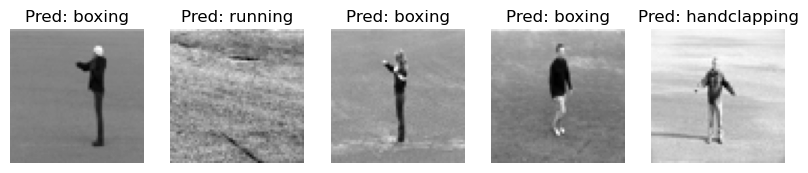

In [45]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i].reshape(IMG_SIZE), cmap='gray')
    ax.set_title(f"Pred: {categories[y_pred[i]]}")
    ax.axis("off")
plt.show()

In [47]:
import joblib
model_path = "svm_human_motion.pkl"
joblib.dump(clf, model_path)
print(f"Model saved at {model_path}")

Model saved at svm_human_motion.pkl


In [ ]:
######thresholding
"""
import cv2

#image = cv2.imread(r"C:\Users\Sambit Mallick\Downloads\color-wheels-RYB-RGB.webp")
image=cv2.imread("/Users/aditrichaudhuri/Downloads/extracted_frames/person01_boxing_d2_uncomp.avi_frame13.png")
#image = cv2.resize(image, (500, 500))
#image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh1 = cv2.threshold(image1, 105, 255, cv2.THRESH_BINARY)

cv2.imshow('Binary Threshold', thresh1)
cv2.waitKey(0)
"""

In [11]:
def predict_video(video_path, model_path="svm_human_motion.pkl"):
    clf = joblib.load(model_path)  # Load the saved model
    frames = iio.imread(video_path)
    frame_indices = np.linspace(0, frames.shape[0] - 1, FRAMES_PER_VIDEO, dtype=int)
    
    X_sample = []
    for idx in frame_indices:
        frame = frames[idx]
        frame_img = array_to_img(frame, scale=False).convert("L").resize(IMG_SIZE)
        img_array = img_to_array(frame_img) / 255.0
        img_flattened = img_array.flatten()
        X_sample.append(img_flattened)
    
    X_sample = np.array(X_sample)
    predictions = clf.predict(X_sample)
    final_prediction = np.bincount(predictions).argmax()  # Majority voting
    
    print(f"Predicted Class: {categories[final_prediction]}")
    return categories[final_prediction]

# Example usage
predict_video("/Users/aditrichaudhuri/person01_handwaving_d1_uncomp.avi")

Predicted Class: handclapping


'handclapping'

In [12]:
# Load model and run inference on a single video
def predict_video2(video_path, model_path="svm_human_motion.pkl"):
    clf = joblib.load(model_path)  # Load the saved model
    frames = iio.imread(video_path)
    frame_indices = np.linspace(0, frames.shape[0] - 1, FRAMES_PER_VIDEO, dtype=int)
    
    X_sample = []
    frame_images = []
    for idx in frame_indices:
        frame = frames[idx]
        frame_img = array_to_img(frame, scale=False).convert("L").resize(IMG_SIZE)
        img_array = img_to_array(frame_img) / 255.0
        img_flattened = img_array.flatten()
        X_sample.append(img_flattened)
        frame_images.append(frame_img)
    
    X_sample = np.array(X_sample)
    predictions = clf.predict(X_sample)
    
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(frame_images[i], cmap='gray')
        ax.set_title(f"Pred: {categories[predictions[i]]}")
        ax.axis("off")
    plt.show()
    
    # Majority voting
    unique, counts = np.unique(predictions, return_counts=True)
    if len(unique) == len(categories) or max(counts) <= 6:
        print("No majority class found, hence could not classify.")
        return "No classification"
    else:
        final_prediction = unique[np.argmax(counts)]
        print(f"Predicted Class: {categories[final_prediction]}")
        return categories[final_prediction]

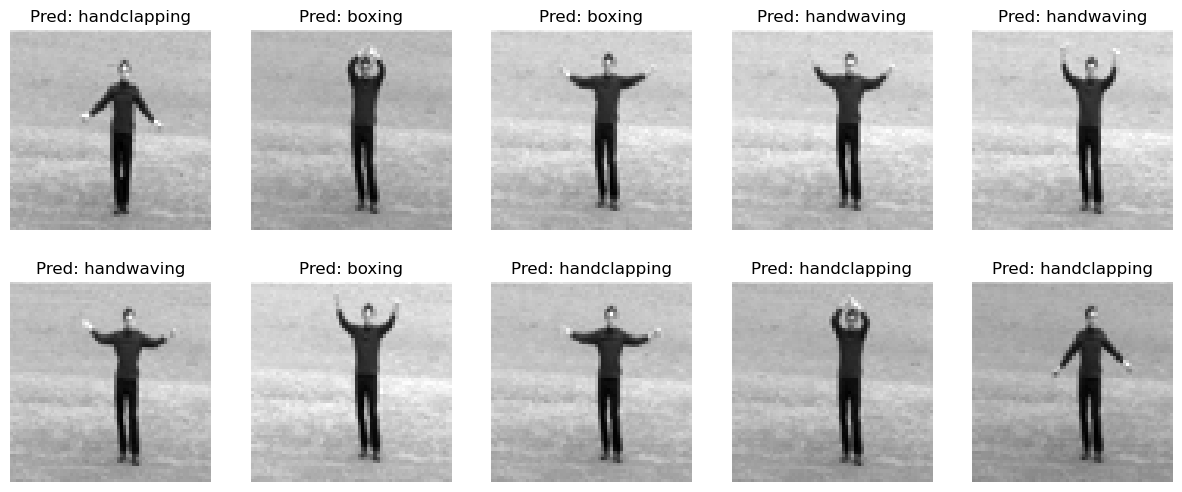

No majority class found, hence could not classify.


'No classification'

In [13]:
predict_video2("/Users/aditrichaudhuri/person01_handwaving_d1_uncomp.avi")

In [14]:
from sklearn.decomposition import PCA

In [16]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf_orig = SVC(kernel='linear')
clf_orig.fit(X_train_orig, y_train)
y_pred_orig = clf_orig.predict(X_test_orig)
accuracy_orig = accuracy_score(y_test, y_pred_orig)

# Training SVM with PCA
n_components = 50
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
X_train_pca, X_test_pca, _, _ = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train a classifier on reduced data
clf_pca = SVC(kernel='linear')
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

In [17]:
print(f"Accuracy without PCA: {accuracy_orig:.4f}")
print(f"Accuracy with PCA ({n_components} components): {accuracy_pca:.4f}")


Accuracy without PCA: 0.6317
Accuracy with PCA (50 components): 0.4817


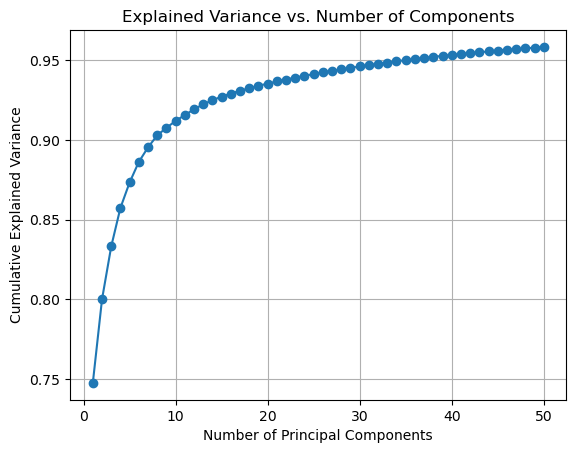

In [18]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, n_components + 1), explained_variance, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.grid()
plt.show()

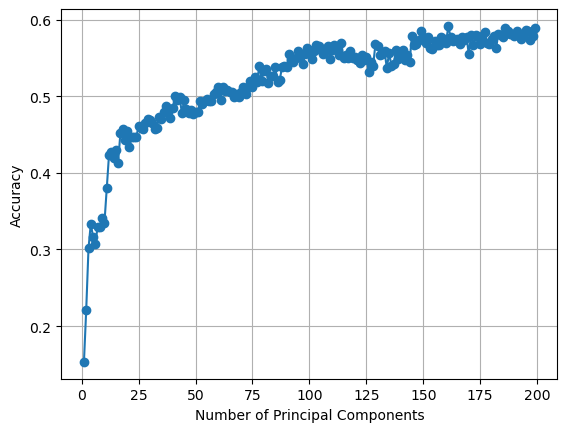

In [19]:
accuracy_scores = []

for n in range(1, 200):
    
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    clf_pca = SVC(kernel='linear')
    clf_pca.fit(X_train_pca, y_train)
    y_pred_pca = clf_pca.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    accuracy_scores.append(accuracy_pca)


plt.plot(range(1, 200), accuracy_scores, marker='o', linestyle='-')
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.grid()
plt.show()


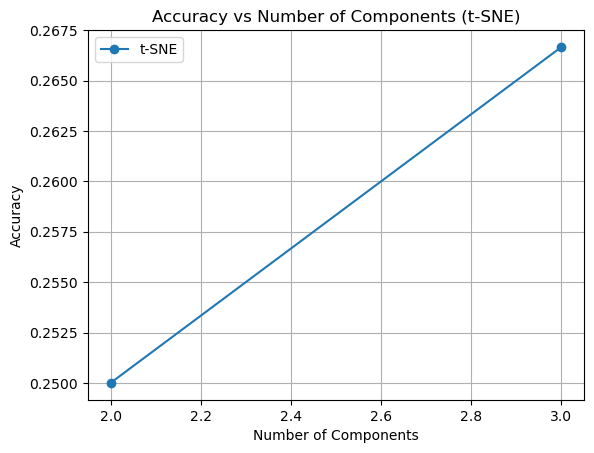

In [20]:

from sklearn.manifold import TSNE

accuracies_tsne = []
components_range = [2,3]

for n in components_range:
    tsne = TSNE(n_components=n, random_state=42)
    X_tsne = tsne.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=0.2, random_state=42)
    
    clf = SVC(kernel='linear')
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies_tsne.append(accuracy)

plt.plot(components_range, accuracies_tsne, marker='o', linestyle='-', label="t-SNE")
plt.xlabel("Number of Components")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Components (t-SNE)")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=0.2, random_state=42)
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f" Accuracy after using t-SNE (with components=3) is {accuracy:.4f}")


 Accuracy after using t-SNE (with components=3) is 0.2667


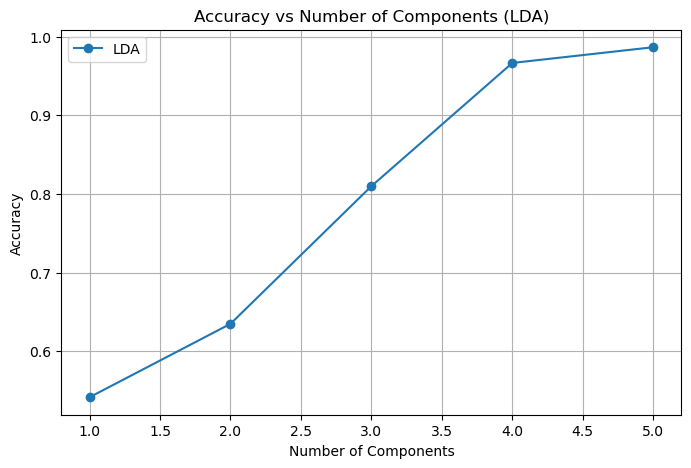

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

accuracies_lda = []
components_range = [1, 2, 3, 4, 5]  # LDA components are limited by the number of classes - 1

for n in components_range:
    lda = LDA(n_components=n)
    X_lda = lda.fit_transform(X, y)  # LDA requires both X and y during fitting

    X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)

    clf = SVC(kernel='linear')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies_lda.append(accuracy)


plt.figure(figsize=(8, 5))
plt.plot(components_range, accuracies_lda, marker='o', linestyle='-', label="LDA")
plt.xlabel("Number of Components")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Components (LDA)")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
lda = LDA(n_components=5)
X_lda = lda.fit_transform(X, y)  # LDA requires class labels

X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy_lda = accuracy_score(y_test, y_pred)
    
print(f"Accuracy after using LDA: {accuracy_lda:.4f}")

Accuracy after using LDA: 0.9867


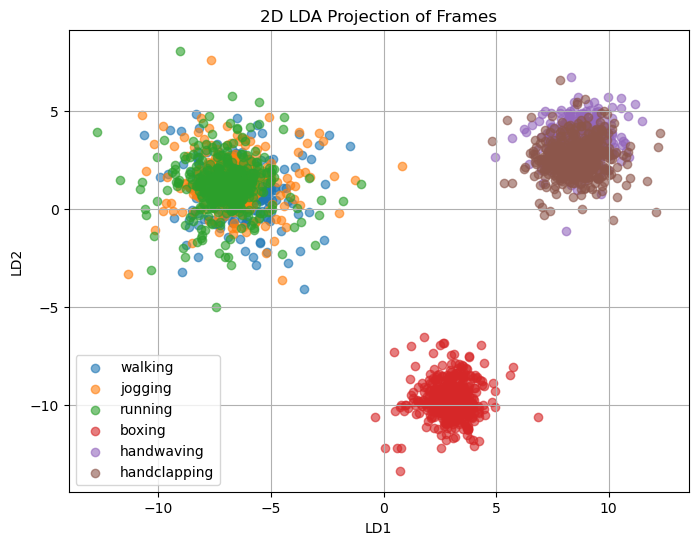

In [29]:
# Reduce features to 2 dimensions for visualization
lda_2d = LDA(n_components=2)
X_lda_2d = lda_2d.fit_transform(X, y)

plt.figure(figsize=(8, 6))
for label in np.unique(y):
    idx = np.where(y == label)
    plt.scatter(X_lda_2d[idx, 0], X_lda_2d[idx, 1], label=categories[label], alpha=0.6)
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("2D LDA Projection of Frames")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
from sklearn.pipeline import Pipeline

# Creating a pipeline that chains LDA and SVM
pipeline = Pipeline([
    ('lda', LDA(n_components=5)),
    ('svm', SVC(kernel='linear'))
])

# Training the pipeline on the full dataset
pipeline.fit(X, y)

# Saving the entire pipeline
joblib.dump(pipeline, "lda_svm_pipeline.pkl")
print("Pipeline saved as 'lda_svm_pipeline.pkl'")

Pipeline saved as 'lda_svm_pipeline.pkl'


In [49]:
# Parameters (must match training settings)
IMG_SIZE = (64, 64)
FRAMES_PER_VIDEO = 10
categories = ["walking", "jogging", "running", "boxing", "handwaving", "handclapping"]

# Loading the saved pipeline (if not already loaded)
pipeline = joblib.load("lda_svm_pipeline.pkl")


In [33]:
# Load model and run inference on a single video
def predict_video_3(video_path, model_path="lda_svm_pipeline.pkl"):
    clf = joblib.load(model_path)  # Load the saved model
    frames = iio.imread(video_path)
    frame_indices = np.linspace(0, frames.shape[0] - 1, FRAMES_PER_VIDEO, dtype=int)
    
    X_sample = []
    frame_images = []
    for idx in frame_indices:
        frame = frames[idx]
        frame_img = array_to_img(frame, scale=False).convert("L").resize(IMG_SIZE)
        img_array = img_to_array(frame_img) / 255.0
        img_flattened = img_array.flatten()
        X_sample.append(img_flattened)
        frame_images.append(frame_img)
    
    X_sample = np.array(X_sample)
    predictions = clf.predict(X_sample)
    
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(frame_images[i], cmap='gray')
        ax.set_title(f"Pred: {categories[predictions[i]]}")
        ax.axis("off")
    plt.show()
    
    # Majority voting
    unique, counts = np.unique(predictions, return_counts=True)
    if len(unique) == len(categories) or max(counts) <= 6:
        print("No majority class found, hence could not classify.")
        return "No classification"
    else:
        final_prediction = unique[np.argmax(counts)]
        print(f"Predicted Class: {categories[final_prediction]}")
        return categories[final_prediction]
        
        

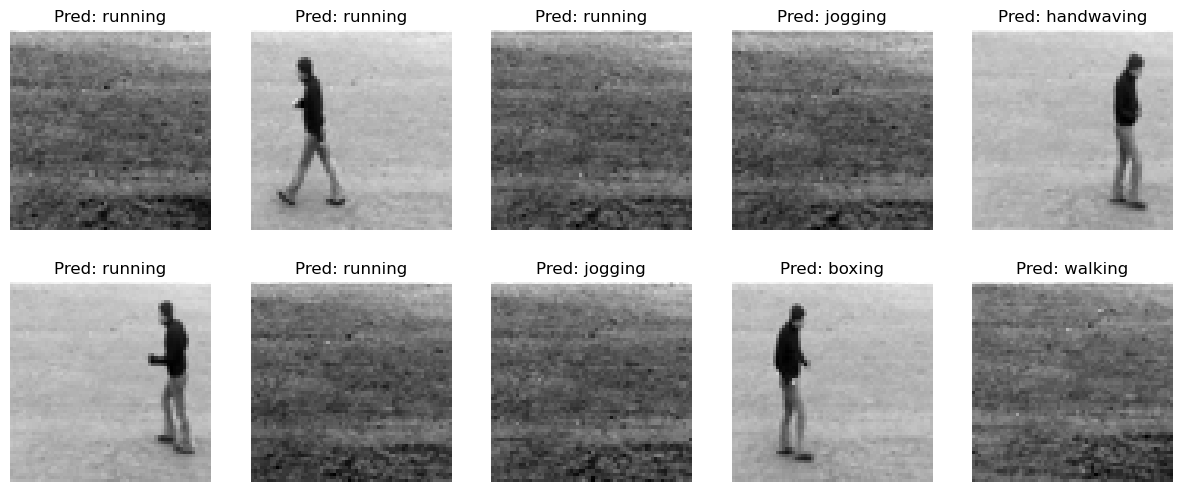

No majority class found, hence could not classify.


'No classification'

In [49]:
predict_video_3("/Users/aditrichaudhuri/person02_walking_d1_uncomp.avi")